In [1]:
#workhorses
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#for custom colormaps
from matplotlib.colors import LinearSegmentedColormap

#for proxy artists for legends
import matplotlib.lines as mlines

import itertools

In [2]:
#plotting aesthetics

import matplotlib as mpl
from cycler import cycler

#All of Anandh's customized seaborn settings
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw,
              "xtick.direction": "in","ytick.direction": "in"})

#custom matplotlib params
mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)

## open data

In [3]:
directory = 'C:/Users/geeze/Box/biocircuits/Reed/projects/DARPA_biocon/Task 1.1/A+pTet-ccdA/20200710 capnresc 4 small ind sets/ind set 1/'

filename = 'cfu_data.xlsx'

datas = pd.read_excel(directory + filename, sheet_name=None)

In [4]:
datas.keys()

dict_keys(['t0', 't1'])

# clean up the data for use

In [5]:
d_list = []
for key in datas.keys():
    d = datas[key]
    
    #this requires there be at least one column just named "cfu"
    d['cfu'] = d['cfu'].replace(0, np.nan)
    
    d = d.dropna(axis='index')
    
    d_list.append(d)
    
    
#one long dataframe
df = pd.concat(d_list).reset_index(drop=True)

In [6]:
#generate one with just means and sd's
list_stat = []
for key in datas.keys():
    d = datas[key]
    
    df_mean = d.groupby(['well'])['cfu'].mean()
    df_std = d.groupby(['well'])['cfu'].std()
    
    df_std = df_std.rename('std')
    
    df_stat = pd.concat([df_mean, df_std], axis=1)
    df_stat['time'] = d['time'].unique()[0]
    
    df_stat = df_stat.reset_index()
    
    list_stat.append(df_stat)
    
    
#make one long dataframe
df_stat = pd.concat(list_stat).reset_index(drop=True)

In [7]:
# log transformation

df['cfu_log'] = df['cfu'].apply(np.log10)
df_stat['cfu_log'] = df['cfu'].apply(np.log10)

## plot

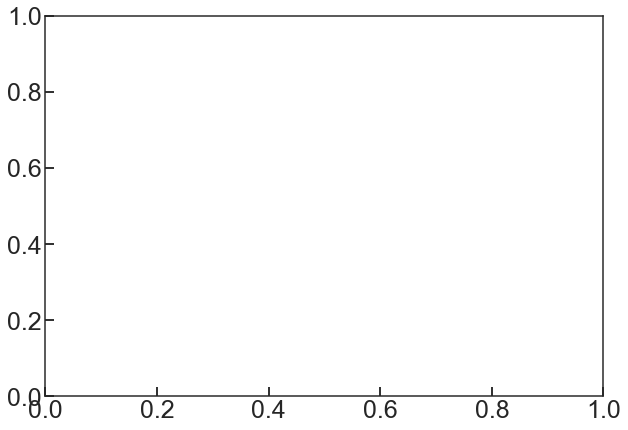

In [8]:
#create master figure
fig, ax = plt.subplots(figsize=(10,7))

In [32]:
sns.pointplot(x='time', y='cfu_log', data=df_stat, hue='well', ci=None, ax=ax)
#sns.stripplot(x='time', y='cfu', data=df_stat, hue='well', ax=ax)

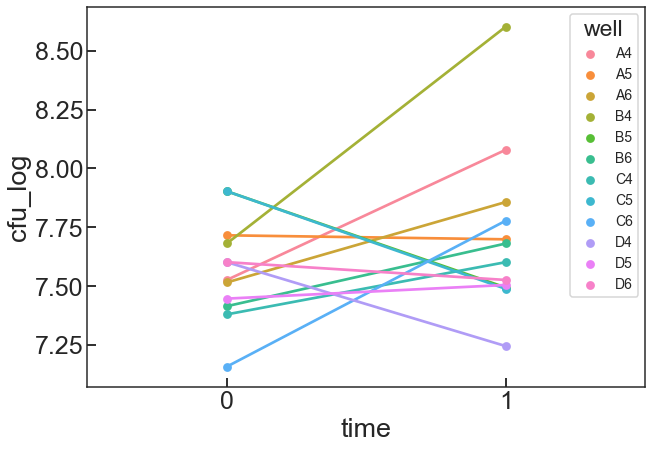

In [33]:
fig

In [123]:
# fig.savefig(directory + 'totalCFUml_bulkgated_384plate3adjust.pdf')